In [0]:
# Importing Libraries

In [0]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR"

HAR_EDA.ipynb  HAR_LSTM.ipynb  HAR_PREDICTION_MODELS.ipynb  UCI_HAR_Dataset


In [0]:
import pandas as pd
import numpy as np


In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = '/content/drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    #return pd.get_dummies(y)
    return y

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
tf.compat.v1.enable_eager_execution()

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
#n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(X_train.shape)

128
9
7352
(7352, 128, 9)


In [0]:
Y_train

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

## Defining the Architecture of LSTM

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.3018 - acc: 0.4395 - val_loss: 1.1254 - val_acc: 0.4662
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9666 - acc: 0.5880 - val_loss: 0.9491 - val_acc: 0.5714
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.7812 - acc: 0.6408 - val_loss: 0.8286 - val_acc: 0.5850
Epoch 4/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6941 - acc: 0.6574 - val_loss: 0.7297 - val_acc: 0.6128
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6336 - acc: 0.6912 - val_loss: 0.7359 - val_acc: 0.6787
Epoch 6/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5859 - acc: 0.7134 - val_loss: 0.7015 - val_acc: 0.6939
Epoch 7/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.5692 - acc: 0.7477 - val_loss: 0.5995 - val_acc: 0.7387


In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [0]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

## LSTM layer with hidden units 50

In [0]:
epochs = 30
batch_size = 16
n_hidden = 50

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.2245 - accuracy: 0.4805 - val_loss: 0.9273 - val_accuracy: 0.6291
Epoch 2/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.7986 - accuracy: 0.6435 - val_loss: 0.7593 - val_accuracy: 0.6322
Epoch 3/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.7042 - accuracy: 0.6668 - val_loss: 0.7221 - val_accuracy: 0.6491
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.5705 - accuracy: 0.7715 - val_loss: 0.6119 - val_accuracy: 0.7933
Epoch 5/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.4533 - accuracy: 0.8498 - val_loss: 0.4484 - val_accuracy: 0.8459
Epoch 6/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.3434 - accuracy: 0.8980 - val_loss: 0.5086 - val_accuracy: 0.8402
Epoch 7/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.278

## LSTM layer with hidden units 100

In [0]:
epochs = 30
batch_size = 16
n_hidden = 100

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 44,606
Trainable params: 44,606
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 43s 6ms/step - loss: 1.2099 - accuracy: 0.4747 - val_loss: 1.1969 - val_accuracy: 0.4880
Epoch 2/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.8234 - accuracy: 0.6240 - val_loss: 0.8039 - val_accuracy: 0.6373
Epoch 3/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.6561 - accuracy: 0.7212 - val_loss: 0.7731 - val_accuracy: 0.7431
Epoch 4/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.4594 - accuracy: 0.8358 - val_loss: 0.5050 - val_accuracy: 0.8575
Epoch 5/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.3005 - accuracy: 0.9014 - val_loss: 0.4458 - val_accuracy: 0.8700
Epoch 6/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.2409 - accuracy: 0.9187 - val_loss: 0.9047 - val_accuracy: 0.8144
Epoch 7/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.214

## LSTM layer with hidden units 50 and Stacked 2 LSTM layer 

In [0]:
epochs = 30
batch_size = 16
n_hidden = 50

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 50)           12000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306       
Total params: 32,506
Trainable params: 32,506
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 61s 8ms/step - loss: 1.0297 - accuracy: 0.5866 - val_loss: 1.0364 - val_accuracy: 0.5786
Epoch 2/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.6456 - accuracy: 0.7368 - val_loss: 0.5441 - val_accuracy: 0.7659
Epoch 3/30
7352/7352 [==============================] - 62s 8ms/step - loss: 0.5060 - accuracy: 0.8007 - val_loss: 0.5274 - val_accuracy: 0.7947
Epoch 4/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.3760 - accuracy: 0.8837 - val_loss: 0.3860 - val_accuracy: 0.8799
Epoch 5/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.2305 - accuracy: 0.9261 - val_loss: 0.5078 - val_accuracy: 0.8619
Epoch 6/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.1899 - accuracy: 0.9397 - val_loss: 0.5318 - val_accuracy: 0.8853
Epoch 7/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.173

## LSTM layer with hidden units 100 and Stacked 2 LSTM layer with Dropout 0.7

In [0]:
epochs = 30
batch_size = 16
n_hidden = 100

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True,))
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 100)          44000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 606       
Total params: 125,006
Trainable params: 125,006
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 87s 12ms/step - loss: 1.0227 - accuracy: 0.5442 - val_loss: 1.3878 - val_accuracy: 0.4710
Epoch 2/30
7352/7352 [==============================] - 87s 12ms/step - loss: 0.7390 - accuracy: 0.6786 - val_loss: 0.7332 - val_accuracy: 0.7106
Epoch 3/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.5430 - accuracy: 0.7961 - val_loss: 0.4565 - val_accuracy: 0.8592
Epoch 4/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.3026 - accuracy: 0.9083 - val_loss: 0.4813 - val_accuracy: 0.8772
Epoch 5/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.2307 - accuracy: 0.9212 - val_loss: 0.3086 - val_accuracy: 0.9108
Epoch 6/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.1905 - accuracy: 0.9363 - val_loss: 0.8151 - val_accuracy: 0.8459
Epoch 7/30
7352/7352 [==============================] - 90s 12ms/step - loss

## LSTM layer with hidden units 200 and Stacked 2 LSTM Layer with Dropout 0.7

In [0]:
epochs = 30
batch_size = 16
n_hidden = 200

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128, 200)          168000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 1206      
Total params: 490,006
Trainable params: 490,006
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),a
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 201s 27ms/step - loss: 1.2386 - accuracy: 0.4478 - val_loss: 1.2469 - val_accuracy: 0.4601
Epoch 2/30
7352/7352 [==============================] - 198s 27ms/step - loss: 1.1362 - accuracy: 0.4927 - val_loss: 1.0139 - val_accuracy: 0.5300
Epoch 3/30
7352/7352 [==============================] - 199s 27ms/step - loss: 1.1668 - accuracy: 0.4853 - val_loss: 0.8508 - val_accuracy: 0.6016
Epoch 4/30
7352/7352 [==============================] - 198s 27ms/step - loss: 0.7243 - accuracy: 0.6404 - val_loss: 0.7373 - val_accuracy: 0.6077
Epoch 5/30
7352/7352 [==============================] - 199s 27ms/step - loss: 0.6769 - accuracy: 0.6869 - val_loss: 1.3507 - val_accuracy: 0.5921
Epoch 6/30
7352/7352 [==============================] - 199s 27ms/step - loss: 0.4137 - accuracy: 0.8570 - val_loss: 0.4040 - val_accuracy: 0.8565
Epoch 7/30
7352/7352 [==============================] - 199s 27ms/step

In [0]:
epochs = 30
batch_size = 50
n_hidden = 400

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128, 400)          656000    
_________________________________________________________________
lstm_19 (LSTM)               (None, 400)               1281600   
_________________________________________________________________
dropout_9 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 2406      
Total params: 1,940,006
Trainable params: 1,940,006
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 376s 51ms/step - loss: 1.3895 - accuracy: 0.3630 - val_loss: 1.4433 - val_accuracy: 0.3448
Epoch 2/30
7352/7352 [==============================] - 371s 50ms/step - loss: 1.5051 - accuracy: 0.3419 - val_loss: 1.3643 - val_accuracy: 0.3536
Epoch 3/30
7352/7352 [==============================] - 367s 50ms/step - loss: 1.6174 - accuracy: 0.2947 - val_loss: 2.2827 - val_accuracy: 0.1805
Epoch 4/30
7352/7352 [==============================] - 372s 51ms/step - loss: 1.3847 - accuracy: 0.3663 - val_loss: 1.2864 - val_accuracy: 0.3885
Epoch 5/30
7352/7352 [==============================] - 377s 51ms/step - loss: 1.3023 - accuracy: 0.4094 - val_loss: 1.4268 - val_accuracy: 0.3427
Epoch 6/30
7352/7352 [==============================] - 376s 51ms/step - loss: 1.5229 - accuracy: 0.3307 - val_loss: 1.3071 - val_accuracy: 0.4007
Epoch 7/30
7352/7352 [==============================] - 365s 50ms/step

# DIVIDE MY CONQUER USING CNN

In [0]:
!ls "drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset/train"

'Inertial Signals'   subject_train.txt	 X_train.txt   y_train.txt


In [0]:
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense,Dropout,CuDNNLSTM,BatchNormalization
from keras.layers import Conv1D,MaxPooling1D,Flatten
from keras.layers.embeddings import Embedding


Using TensorFlow backend.


##Loading the Output labels by spliting into Static and Dynamic

In [0]:
#code is taken from this website and modified according to my requirement github.com/xSachinBharadwajx/Human-Activity-Recognition-Using-Smartphones-DivideAndConquer/blob/master/ConquerDivide_HAR.ipynb
def load_op_2(incoming1,incoming2):
  """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
  #path="drive/My Drive/Data/Human_activity_recognition" +'/'+ incoming +'.txt'
  path="drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset/"+incoming2+'/'+incoming1+'.txt'
  df=pd.read_csv(path, delim_whitespace=True, header=None)[0]
  df[df<=3] = 0
  df[df>3] = 1
  return pd.get_dummies(df).to_numpy()

In [0]:
y_train_2=load_op_2('y_train',"train")
y_test_2=load_op_2('y_test',"test")
print(y_train_2.shape)
print(y_test_2.shape)

(7352, 2)
(2947, 2)


##Model for classifying data into Static and Dynamic 

In [0]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train_2, epochs=10, batch_size=16,validation_data=(X_test, y_test_2))

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 6s 760us/step - loss: 0.0345 - accuracy: 0.9868 - val_loss: 0.0338 - val_accuracy: 0.9783
Epoch 2/10
7352/7352 [==============================] - 5s 727us/step - loss: 0.0032 - accuracy: 0.9988 - val_loss: 0.0117 - val_accuracy: 0.9963
Epoch 3/10
7352/7352 [==============================] - 6s 755us/step - loss: 8.8948e-04 - accuracy: 0.9996 - val_loss: 0.0077 - val_accuracy: 0.9983
Epoch 4/10
7352/7352 [==============================] - 5s 710us/step - loss: 6.0257e-05 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9983
Epoch 5/10
7352/7352 [==============================] - 5s 666us/step - loss: 2.3451e-05 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 0.9983
Epoch 6/10
7352/7352 [==============================] - 5s 658us/step - loss: 1.0934e-05 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 0.9983
Epoch 7/10
7352/7352 [==============================] - 5s 6

##Save the 2 class classification model

In [0]:
model.save('drive/My Drive/Colab Notebooks/HumanActivityRecognition/model_2class.h5')

##Classificaton of Static activities

In [0]:
def load_op_stat(incoming1,incoming2):
  """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
  path="drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset/"+incoming2+'/'+incoming1+'.txt'
  
  df=pd.read_csv(path, delim_whitespace=True, header=None)[0]
  df_subset=df>3
  df=df[df_subset]
  return pd.get_dummies(df).to_numpy(),df_subset

In [0]:
y_train_stat,x_train_size=load_op_stat('y_train','train')
y_test_stat,x_test_size=load_op_stat('y_test','test')
X_train_stat=X_train[x_train_size]
X_test_stat=X_test[x_test_size]
print(y_train_stat.shape)
print(y_test_stat.shape)
print(X_test_stat.shape)
print(X_train_stat.shape)

(4067, 3)
(1560, 3)
(1560, 128, 9)
(4067, 128, 9)


##Model for Static Activities

In [0]:
  model_stat = Sequential()
  model_stat.add(Conv1D(filters=64, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
  model_stat.add(Conv1D(filters=32, kernel_size=3,padding='same', activation='relu',kernel_initializer='he_uniform'))
  model_stat.add(Dropout(0.6))
  model_stat.add(MaxPooling1D(pool_size=1,strides=1))

  model_stat.add(Flatten())
  model_stat.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
  model_stat.add(BatchNormalization()) 
  model_stat.add(Dropout(0.6))

  model_stat.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
  model_stat.add(BatchNormalization()) 
  model_stat.add(Dropout(0.6))

  model_stat.add(Dense(3, activation='softmax'))

  model_stat.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  model_stat.fit(X_train_stat,y_train_stat, epochs=30, batch_size=16,validation_data=(X_test_stat, y_test_stat))

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 4s 1ms/step - loss: 0.5644 - accuracy: 0.7866 - val_loss: 0.4062 - val_accuracy: 0.8487
Epoch 2/30
4067/4067 [==============================] - 4s 965us/step - loss: 0.3247 - accuracy: 0.8844 - val_loss: 0.3619 - val_accuracy: 0.8891
Epoch 3/30
4067/4067 [==============================] - 4s 955us/step - loss: 0.2981 - accuracy: 0.8921 - val_loss: 0.3128 - val_accuracy: 0.8808
Epoch 4/30
4067/4067 [==============================] - 4s 969us/step - loss: 0.2971 - accuracy: 0.8962 - val_loss: 0.3310 - val_accuracy: 0.8679
Epoch 5/30
4067/4067 [==============================] - 4s 954us/step - loss: 0.2567 - accuracy: 0.9019 - val_loss: 0.2835 - val_accuracy: 0.8821
Epoch 6/30
4067/4067 [==============================] - 4s 949us/step - loss: 0.2705 - accuracy: 0.9014 - val_loss: 0.3198 - val_accuracy: 0.8846
Epoch 7/30
4067/4067 [==============================] - 4s 942us/step - loss: 

In [0]:
model_stat.save('drive/My Drive/Colab Notebooks/HumanActivityRecognition/model_stat_class.h5')

##Output For Dynamic Activities

In [0]:
def load_op_dyn(incoming1,incoming2):
  """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
  path="drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/UCI_HAR_Dataset/"+incoming2+'/'+incoming1+'.txt'
  
  df=pd.read_csv(path, delim_whitespace=True, header=None)[0]
  df_subset=df<=3
  df=df[df_subset]
  return pd.get_dummies(df).to_numpy(),df_subset

In [0]:
y_train_dyn,x_train_size=load_op_dyn('y_train','train')
y_test_dyn,x_test_size=load_op_dyn('y_test','test')
X_train_dyn=X_train[x_train_size]
X_test_dyn=X_test[x_test_size]
print(y_train_dyn.shape)
print(y_test_dyn.shape)
print(X_test_dyn.shape)
print(X_train_dyn.shape)

(3285, 3)
(1387, 3)
(1387, 128, 9)
(3285, 128, 9)


##Model for Dynamic

In [0]:
  model_dyn = Sequential()
  model_dyn.add(Conv1D(filters=64, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
  model_dyn.add(Conv1D(filters=32, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform'))
  model_dyn.add(Dropout(0.5))
  model_dyn.add(MaxPooling1D(pool_size=1,strides=1))

  model_dyn.add(Flatten())
  model_dyn.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
  model_dyn.add(BatchNormalization()) 
  model_dyn.add(Dropout(0.5))

  model_dyn.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
  model_dyn.add(BatchNormalization()) 
  model_dyn.add(Dropout(0.5))

  model_dyn.add(Dense(3, activation='softmax'))

  model_dyn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_dyn.fit(X_train_dyn,y_train_dyn, epochs=40, batch_size=16,validation_data=(X_test_dyn, y_test_dyn),verbose=1)

  #Evaluate the model_dyn 
  score = model_dyn.evaluate(X_test_dyn, y_test_dyn)

Train on 3285 samples, validate on 1387 samples
Epoch 1/40
3285/3285 [==============================] - 5s 1ms/step - loss: 1.3193 - accuracy: 0.4712 - val_loss: 1.3942 - val_accuracy: 0.4585
Epoch 2/40
3285/3285 [==============================] - 4s 1ms/step - loss: 0.5140 - accuracy: 0.8000 - val_loss: 0.4088 - val_accuracy: 0.8407
Epoch 3/40
3285/3285 [==============================] - 4s 1ms/step - loss: 0.2259 - accuracy: 0.9324 - val_loss: 0.3440 - val_accuracy: 0.8688
Epoch 4/40
3285/3285 [==============================] - 4s 1ms/step - loss: 0.1333 - accuracy: 0.9635 - val_loss: 0.1645 - val_accuracy: 0.9524
Epoch 5/40
3285/3285 [==============================] - 4s 1ms/step - loss: 0.0988 - accuracy: 0.9735 - val_loss: 0.1798 - val_accuracy: 0.9322
Epoch 6/40
3285/3285 [==============================] - 4s 1ms/step - loss: 0.0783 - accuracy: 0.9763 - val_loss: 0.2188 - val_accuracy: 0.9452
Epoch 7/40
3285/3285 [==============================] - 4s 1ms/step - loss: 0.0957 - acc

In [0]:
model_dyn.save('drive/My Drive/Colab Notebooks/HumanActivityRecognition/model_dyn_class.h5')

##Final Prediction 

In [0]:
from keras.models import load_model
import pickle
model_2class = load_model('drive/My Drive/Colab Notebooks/HumanActivityRecognition/model_2class.h5')
model_static = load_model('drive/My Drive/Colab Notebooks/HumanActivityRecognition/model_stat_class.h5')
model_dynamic = load_model('drive/My Drive/Colab Notebooks/HumanActivityRecognition/model_dyn_class.h5')

In [0]:
predict_2class = model_2class.predict(X_test)
Y_pred_2class =  np.argmax(predict_2class, axis=1)
#static data filter
X_static = X_test[Y_pred_2class==1]
#dynamic data filter
X_dynamic = X_test[Y_pred_2class==0]

In [0]:
predict_static = model_static.predict(X_static)
predict_static = np.argmax(predict_static,axis=1)
#predict_static = predict_static + 4

In [0]:
predict_static

array([1, 1, 1, ..., 2, 2, 2])

In [0]:
predict_static = predict_static + 4

In [0]:
predict_static

array([5, 5, 5, ..., 6, 6, 6])

In [0]:
predict_dynamic = model_dynamic.predict(X_dynamic)
predict_dynamic = np.argmax(predict_dynamic,axis=1)
#predict_dynamic = predict_dynamic + 1

In [0]:
predict_dynamic

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
predict_dynamic = predict_dynamic + 1

In [0]:
predict_dynamic

array([1, 1, 1, ..., 2, 2, 2])

In [0]:
i,j = 0,0 
final_pred = []
for mask in Y_pred_2class:
    if mask == 1:
        final_pred.append(predict_static[i])
        i = i + 1
    else:
        final_pred.append(predict_dynamic[j])
        j = j + 1

In [0]:
from sklearn.metrics import accuracy_score
print('Accuracy of test data',accuracy_score(Y_test,final_pred))

Accuracy of test data 0.9314557176789956


In [0]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##CONFUSION MATRIX

In [0]:
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

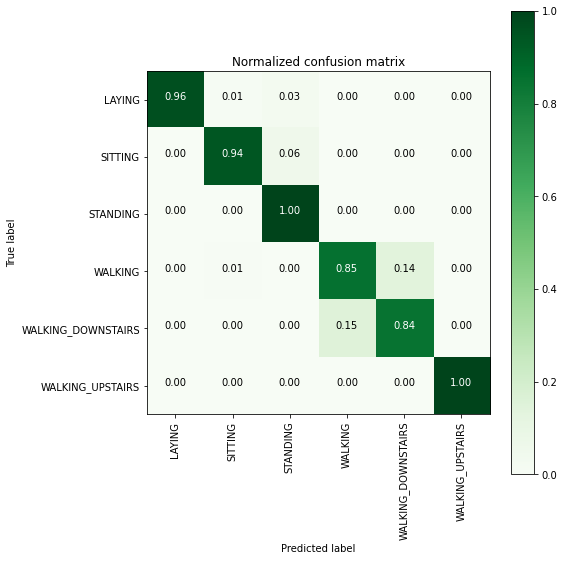

In [0]:
    cm = confusion_matrix(Y_test, final_pred)
    #results['confusion_matrix'] = cm
  
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
    plt.show()

## CONCLUSION

In [0]:
from prettytable import PrettyTable

In [0]:
pt=PrettyTable()
pt.field_names=["Model","number of units","dropout","train accuracy","test accuracy"]
pt.add_row(["single LSTM","32","0.5","0.9414","0.9097"])
pt.add_row(["single LSTM","50","0.5","0.9504","0.9114"])
pt.add_row(["single LSTM","100","0.5","0.9498","0.9097"])
pt.add_row(["Stacked 2 LSTM layer","50","0.5","0.9532","0.9152"])
pt.add_row(["stacked 2 LSTM layer","100","0.7","0.9516","0.9206"])
pt.add_row(["Stcked 2 LSTM layer","200","0.7","0.9461","0.9135"])
print(pt)


+----------------------+------------------+---------+----------------+---------------+
|        Model         | nuumber of units | dropout | train accuracy | test accuracy |
+----------------------+------------------+---------+----------------+---------------+
|     single LSTM      |        32        |   0.5   |     0.9414     |     0.9097    |
|     single LSTM      |        50        |   0.5   |     0.9504     |     0.9114    |
|     single LSTM      |       100        |   0.5   |     0.9498     |     0.9097    |
| Stacked 2 LSTM layer |        50        |   0.5   |     0.9532     |     0.9152    |
| stacked 2 LSTM layer |       100        |   0.7   |     0.9516     |     0.9206    |
| Stcked 2 LSTM layer  |       200        |   0.7   |     0.9461     |     0.9135    |
+----------------------+------------------+---------+----------------+---------------+


In [4]:
pt=PrettyTable()
pt.field_names=["Model","test accuracy"]
pt.add_row(["Divide and conquer CNN","0.9314557176789956"])
print(pt)

+------------------------+--------------------+
|         Model          |   test accuracy    |
+------------------------+--------------------+
| Divide and conquer CNN | 0.9314557176789956 |
+------------------------+--------------------+
